In [1]:
import pandas as pd
from pandas import DataFrame, Series
from sklearn.cluster import KMeans as km
from sklearn.metrics import silhouette_samples, silhouette_score
import random

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
TRIP_FILE = ('201508_trip_data.csv')
#WEATHER = ('201508_weather_data.csv')
#STATION_BALANCE = ('201508_status_data.csv')
STATION_DATA = ('201508_station_data.csv')

trip_data = pd.read_csv(TRIP_FILE)
#weather_data = pd.read_csv(WEATHER)
#station_balance_data = pd.read_csv(STATION_BALANCE)
station_data = pd.read_csv(STATION_DATA)

trip_data.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


In [3]:
station_data_sf = station_data[station_data.landmark == 'San Francisco'].copy()
station_data_sf.head()

,station_id,name,lat,long,dockcount,landmark,installation
32,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,8/19/2013
33,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,8/19/2013
34,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,8/19/2013
35,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,8/19/2013
36,47,Post at Kearney,37.788975,-122.403452,19,San Francisco,8/19/2013


In [4]:
trip_data = trip_data.merge(station_data[['station_id', 'lat', 'long', 'landmark']], left_on = 'Start Terminal', right_on = 'station_id')
#trip_data.join(station_data, on='station_id')
trip_data = trip_data.merge(station_data[['station_id', 'lat', 'long']], left_on = 'End Terminal', right_on = 'station_id')

trip_data.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,station_id_x,lat_x,long_x,landmark,station_id_y,lat_y,long_y
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
2,913009,725,8/31/2015 17:40,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:53,San Francisco Caltrain (Townsend at 4th),70,360,Subscriber,94111,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
3,912956,1034,8/31/2015 17:31,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:48,San Francisco Caltrain (Townsend at 4th),70,587,Subscriber,94087,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
4,912776,871,8/31/2015 16:50,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:04,San Francisco Caltrain (Townsend at 4th),70,371,Subscriber,94070,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


In [5]:
trip_data_sf = trip_data[trip_data.landmark == 'San Francisco'].copy()
trip_data_sf.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,station_id_x,lat_x,long_x,landmark,station_id_y,lat_y,long_y
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
2,913009,725,8/31/2015 17:40,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:53,San Francisco Caltrain (Townsend at 4th),70,360,Subscriber,94111,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
3,912956,1034,8/31/2015 17:31,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:48,San Francisco Caltrain (Townsend at 4th),70,587,Subscriber,94087,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
4,912776,871,8/31/2015 16:50,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:04,San Francisco Caltrain (Townsend at 4th),70,371,Subscriber,94070,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


In [6]:
trip_data_sf.rename(columns={'station_id_x': 'start_station', 'lat_x': 'start_lat', 'long_x': 'start_long', 'station_id_y': 'end_station', 'lat_y': 'end_lat', 'long_y': 'end_long'}, inplace=True)
#trip_data_sf.drop('name', axis=1, inplace=True)
trip_data_sf.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,start_station,start_lat,start_long,landmark,end_station,end_lat,end_long
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
2,913009,725,8/31/2015 17:40,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:53,San Francisco Caltrain (Townsend at 4th),70,360,Subscriber,94111,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
3,912956,1034,8/31/2015 17:31,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:48,San Francisco Caltrain (Townsend at 4th),70,587,Subscriber,94087,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
4,912776,871,8/31/2015 16:50,Harry Bridges Plaza (Ferry Building),50,8/31/2015 17:04,San Francisco Caltrain (Townsend at 4th),70,371,Subscriber,94070,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


In [7]:
list(trip_data_sf.columns.values)

['Trip ID',
 'Duration',
 'Start Date',
 'Start Station',
 'Start Terminal',
 'End Date',
 'End Station',
 'End Terminal',
 'Bike #',
 'Subscriber Type',
 'Zip Code',
 'start_station',
 'start_lat',
 'start_long',
 'landmark',
 'end_station',
 'end_lat',
 'end_long']

In [8]:
def measure_distance(start_lat, start_long, end_lat, end_long):
    x_difference = start_lat - end_lat
    y_difference = start_long - end_long
    x_squared = x_difference**2
    y_squared = y_difference**2
    added = x_squared + y_squared
    squart_root_ = np.sqrt(added)
    to_feet = squart_root_ * 2390.31 / 0.0082459784137541101
    return to_feet

In [9]:
def compute_distance_df(trip_data_sf, start_lat_name, start_long_name, end_lat_name, end_long_name):
    distances_list = []
    for row in trip_data_sf.index:
        distance_between_points = measure_distance(trip_data_sf[start_lat_name][row], trip_data_sf[start_long_name][row],\
                                trip_data_sf[end_lat_name][row], trip_data_sf[end_long_name][row])
        #print(distance_between_points)
        distances_list.append(distance_between_points)
        #print(distances_list)
    return distances_list

In [10]:
distances_list = compute_distance_df(trip_data_sf,"start_lat","start_long","end_lat","end_long")

In [11]:
trip_data_sf['distance_start_stop'] = distances_list

In [12]:
trip_data_sf.distance_start_stop

0           5451.037117
1           5451.037117
2           5451.037117
3           5451.037117
4           5451.037117
5           5451.037117
6           5451.037117
7           5451.037117
8           5451.037117
9           5451.037117
10          5451.037117
11          5451.037117
12          5451.037117
13          5451.037117
14          5451.037117
15          5451.037117
16          5451.037117
17          5451.037117
18          5451.037117
19          5451.037117
20          5451.037117
21          5451.037117
22          5451.037117
23          5451.037117
24          5451.037117
25          5451.037117
26          5451.037117
27          5451.037117
28          5451.037117
29          5451.037117
              ...      
321084      7664.845591
321085      7664.845591
321086      7664.845591
321087      7664.845591
321088      7664.845591
321089      7664.845591
321090      7664.845591
321091      7664.845591
321092      7664.845591
321093      7664.845591
321094      7664

In [13]:
#Converting 'str' objects to 'int'in col='Duration'
list(map(int, trip_data['Duration']))

[765,
 886,
 725,
 1034,
 871,
 649,
 641,
 920,
 666,
 1106,
 1181,
 1852,
 2189,
 2081,
 2075,
 2115,
 684,
 672,
 770,
 649,
 796,
 462,
 718,
 1041,
 675,
 779,
 718,
 893,
 1130,
 701,
 659,
 643,
 728,
 928,
 681,
 703,
 528,
 774,
 818,
 927,
 602,
 679,
 662,
 696,
 638,
 1104,
 661,
 623,
 587,
 694,
 925,
 671,
 853,
 710,
 552,
 676,
 520,
 990,
 770,
 779,
 807,
 979,
 995,
 792,
 836,
 1129,
 746,
 753,
 661,
 673,
 632,
 800,
 846,
 728,
 752,
 632,
 745,
 515,
 615,
 618,
 720,
 822,
 923,
 690,
 775,
 617,
 1065,
 662,
 743,
 895,
 677,
 589,
 697,
 843,
 660,
 881,
 806,
 1097,
 755,
 607,
 645,
 900,
 568,
 648,
 792,
 764,
 631,
 732,
 639,
 593,
 927,
 637,
 707,
 786,
 570,
 850,
 874,
 852,
 661,
 1163,
 853,
 694,
 858,
 622,
 604,
 702,
 698,
 1340,
 743,
 802,
 920,
 748,
 671,
 758,
 750,
 612,
 882,
 1096,
 930,
 626,
 635,
 577,
 716,
 502,
 962,
 907,
 959,
 676,
 619,
 814,
 486,
 796,
 1372,
 1349,
 684,
 786,
 1188,
 767,
 730,
 744,
 914,
 669,
 779,
 8

In [14]:
#Converting to datetime
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'])
#trip_data['End Date'] = pd.to_datetime(trip_data['End Date'])

[-10, 4000, -10, 11000]

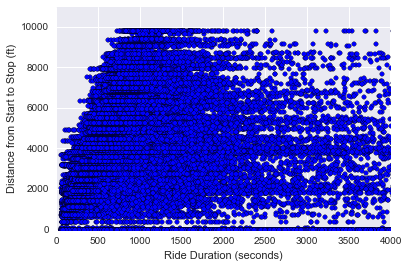

In [15]:
plt.scatter(trip_data_sf['Duration'], trip_data_sf['distance_start_stop'])
plt.xlabel('Ride Duration (seconds)')
plt.ylabel('Distance from Start to Stop (ft)')
plt.axis([-10, 4000, -10, 11000])
#plt.figure(figsize=(20,20))

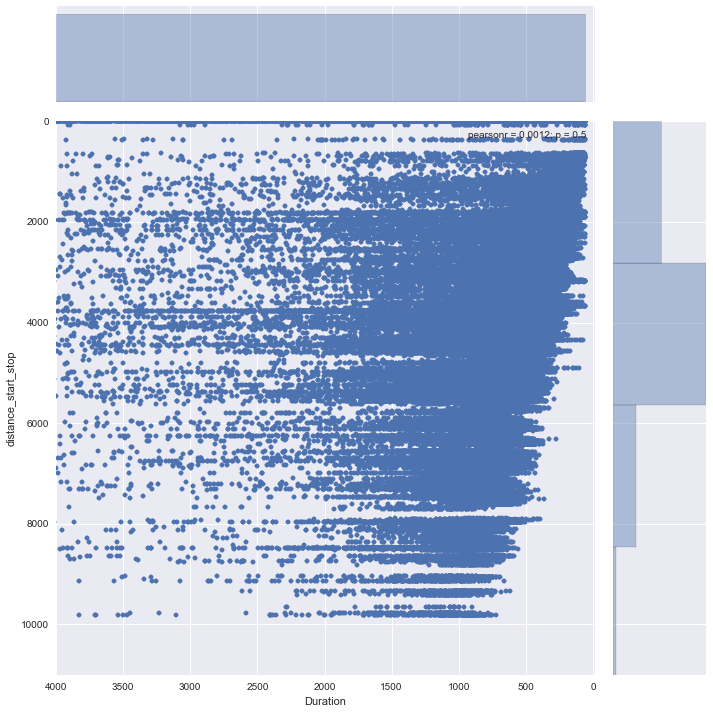

In [16]:
sns.jointplot(trip_data_sf['Duration'], trip_data_sf['distance_start_stop'], kind='scatter', size=10, xlim={-10, 4000}, ylim={-10,11000})

In [17]:
features = trip_data_sf[['Duration', 'distance_start_stop']].copy()
features['day_of_week'] = pd.DatetimeIndex(trip_data_sf['Start Date']).dayofweek
features['hours'] = pd.DatetimeIndex(trip_data_sf['Start Date']).hour

In [18]:
features.head()

,Duration,distance_start_stop,day_of_week,hours
0,765,5451.037117,0,23
1,886,5451.037117,0,18
2,725,5451.037117,0,17
3,1034,5451.037117,0,17
4,871,5451.037117,0,16


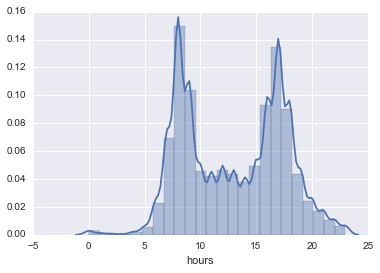

In [19]:
sns.distplot(features['hours'], bins=24, hist=True)

(array([ 57820.,  60517.,  59414.,  57324.,  52616.,  18752.,  14662.]),
 array([ 0.        ,  0.85714286,  1.71428571,  2.57142857,  3.42857143,
         4.28571429,  5.14285714,  6.        ]),
 <a list of 7 Patch objects>)

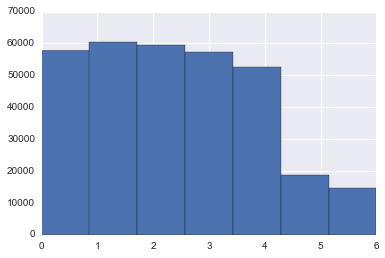

In [20]:
plt.hist(features['day_of_week'], bins=7)

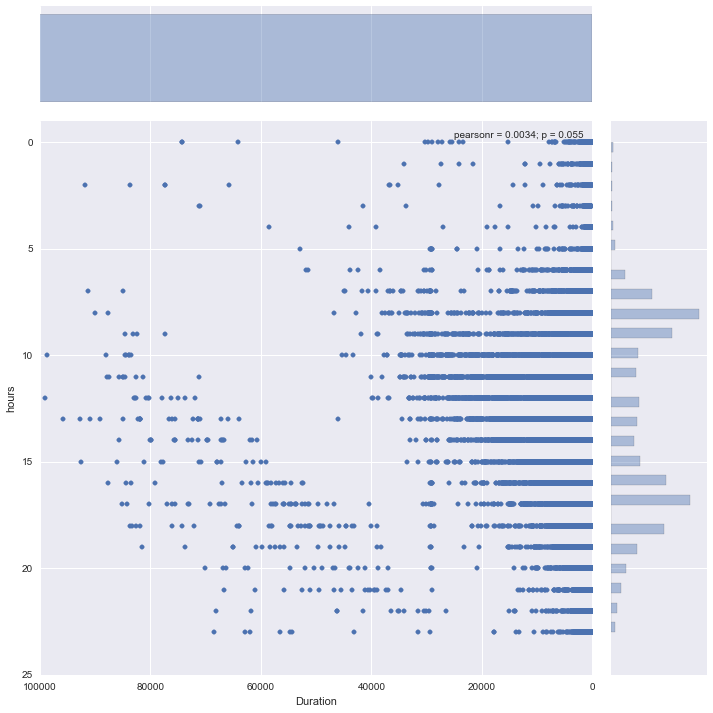

In [21]:
#plt.scatter(features.distance_start_stop, features.hours)
sns.jointplot(features.Duration, features.hours, kind='scatter', size=10, xlim={-1, 100000}, ylim={-1,25})

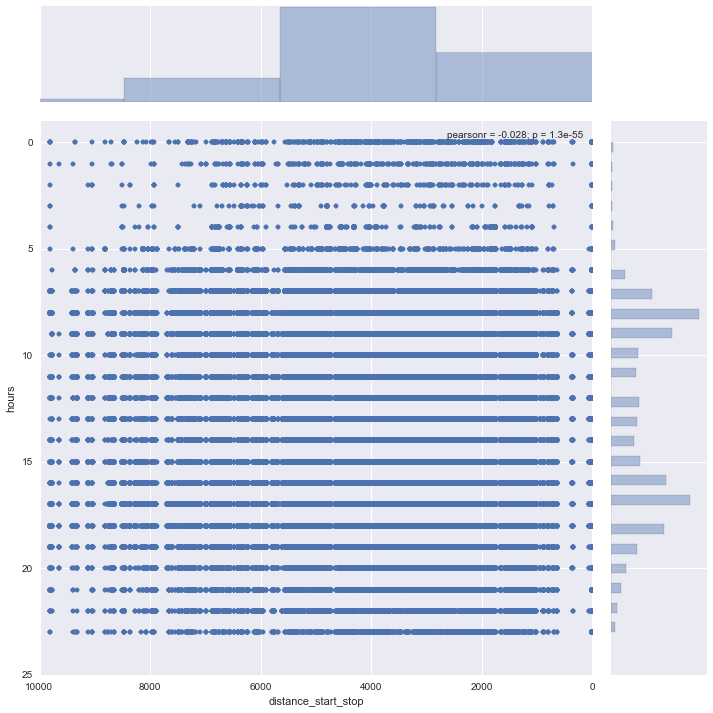

In [22]:
sns.jointplot(features.distance_start_stop, features.hours, kind='scatter', size=10, xlim={-1, 10000}, ylim={-1,25})

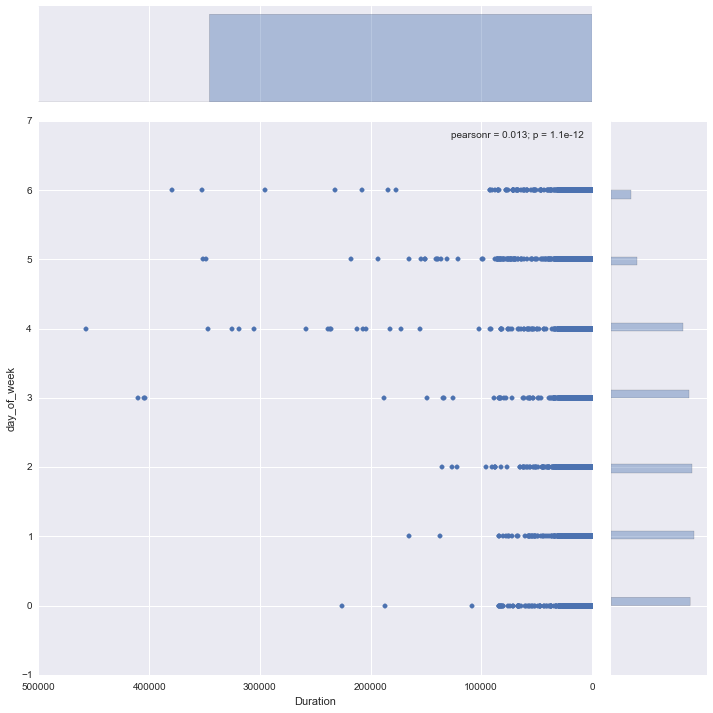

In [23]:
sns.jointplot(features.Duration, features.day_of_week, kind='scatter', size=10, xlim={-1, 500000}, ylim={-1,7})

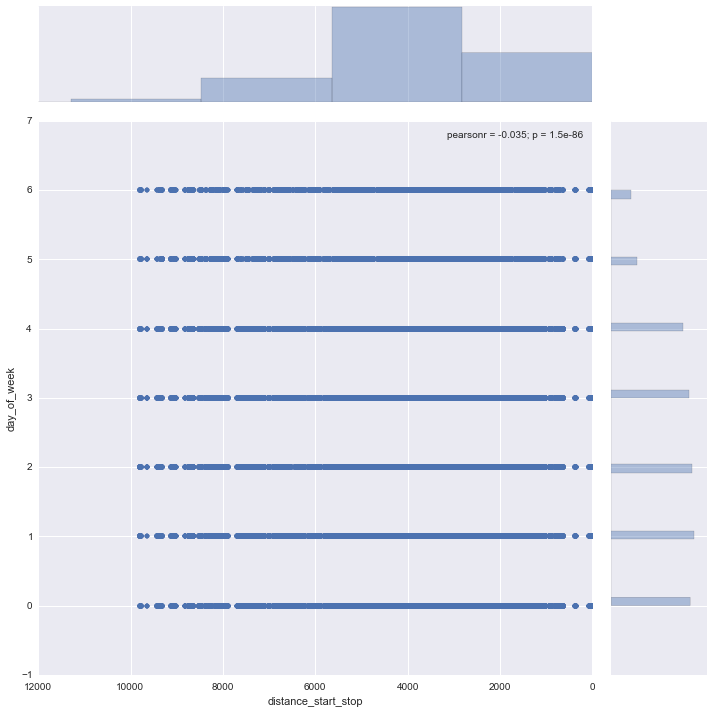

In [24]:
#sns.barplot(features.day_of_week, features.distance_start_stop)
sns.jointplot(features.distance_start_stop, features.day_of_week, kind='scatter', size=10, xlim={-1, 12000}, ylim={-1,7})

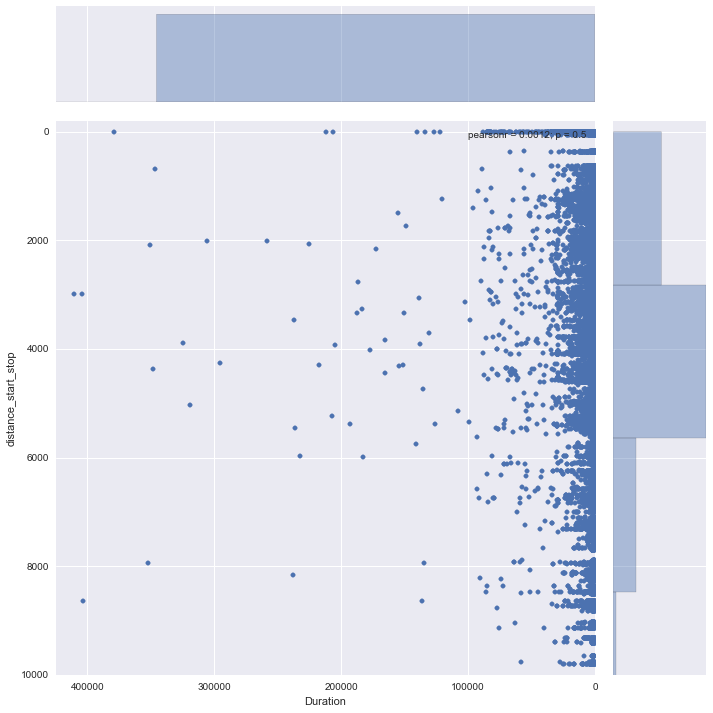

In [25]:
sns.jointplot(features.Duration, features.distance_start_stop, kind='scatter', size=10, xlim={-1, 425000}, ylim={-200,10000})

In [26]:
#from sklearn.preprocessing import scale
#features_scaled = scale(features)

In [27]:
cluster_num = 5
model = km(n_clusters=cluster_num, n_init=10, max_iter=100)
#K = range(1,10)
#model = [km(features,k) for k in K]
#centroids = [cent for (cent,var) in model]
model.fit_transform(features)
features['labels'] = model.labels_
print(features.head())
print(features['labels'].unique())

   Duration  distance_start_stop  day_of_week  hours  labels
0       765          5451.037117            0     23       2
1       886          5451.037117            0     18       2
2       725          5451.037117            0     17       2
3      1034          5451.037117            0     17       2
4       871          5451.037117            0     16       2
[2 0 4 1 3]


In [36]:
# gap.py
# (c) 2013 Mikael Vejdemo-Johansson
# BSD License
#
# SciPy function to compute the gap statistic for evaluating k-means clustering.
# Gap statistic defined in
# Tibshirani, Walther, Hastie:
#  Estimating the number of clusters in a data set via the gap statistic
#  J. R. Statist. Soc. B (2001) 63, Part 2, pp 411-423

import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

def gap(data, refs=None, nrefs=5, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.
    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.
    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = data.max(axis=0)
        bots = data.min(axis=0)
        dists = scipy.matrix(scipy.diag(tops-bots))
    

    rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))
    for i in range(nrefs):
        rands[i] = rands[i]*dists+bots
    else:
        rands = refs

    gaps = scipy.zeros((len(ks),))
    for (i,k) in enumerate(ks):
        (kmc,kml) = scipy.cluster.vq.kmeans2(data, k)
    disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])

    refdisps = scipy.zeros((rands.shape[2],))
    for j in range(rands.shape[2]):
        (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
        refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
    gaps[i] = scipy.log(scipy.mean(refdisps))-scipy.log(disp)
    return gaps
gap(features)


Exception: Data must be 1-dimensional